# Principles of a bootstrap analysis of stable clusters
This tutorial illustrates the basic principles behind the "Bootstrap Analysis of Stable Clusters (BASC)" algorithm, using basic simulations. 
  * **More documentation**: You can check the following [video](https://www.youtube.com/watch?v=4yAUB-FHyv0&t=751s) for a presentation of the algorithm, as well as applications to resting-state and task-based fMRI. 
  * **.m script**: The notebook and associated .m script are available [here](https://nbviewer.jupyter.org/github/SIMEXP/niak_tutorials/blob/master/niak_tutorial_basc_principles.ipynb).
  * **Time for completion**: this tutorial will take 5-10 minutes to complete. 

We are going to simulate data with a cluster structure. Let's assume we have 100 subjects, 300 brain regions and 3 clusters. The `alpha` parameter will control for the strength of the clustering. 

In [21]:
clear all
% build path
addpath(genpath('../Misc'))
build_path  niak psom hcp

Adding library niak to the search path.

Adding library psom to the search path.

Adding library hcp to the search path.



In [38]:
% Read pheno
[TAB,LABELS_X,LABELS_Y,LABELS_ID] = niak_read_csv('/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/pheno/hcp_all_pheno_clean_nonan_norm.csv');
nb_cluster = 9;   % # of clusters 
y=TAB;

We compute the spatial correlation matrix (across subjects) to see how the cluster structure looks.  

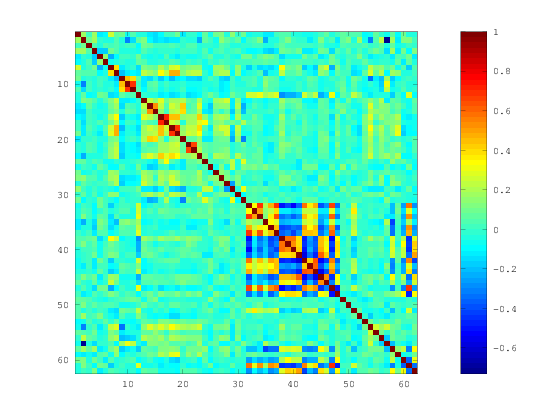

In [39]:
R = corr(y);
title('Spatial correlation matrix')
imagesc(R), axis square, colormap(jet), colorbar

the cluster structure is clear, but noisy. Let's run a hierarchical clustering and see if we can recover it. 

     Percentage done : 0 7 11 16 21 26 31 36 41 46 51 56 61 66 70 75 80 85 90 95 100 Done ! 


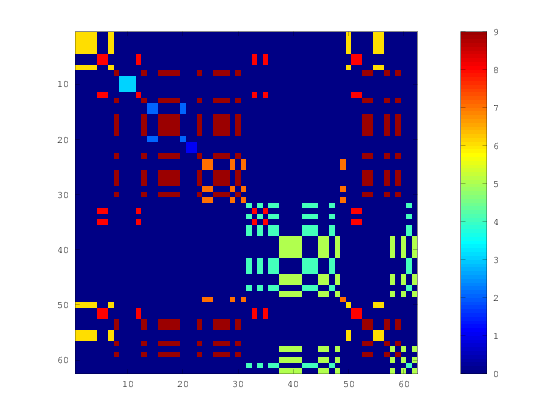

In [40]:
hier = niak_hierarchical_clustering(R); % The similarity-based hierarchical clustering
part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); % threshold the hierarchy to get 3 clusters
niak_visu_part(part) % visualize the partition

If the clustering had done a perfect job, we would have squares on the diagonal.let's odre it

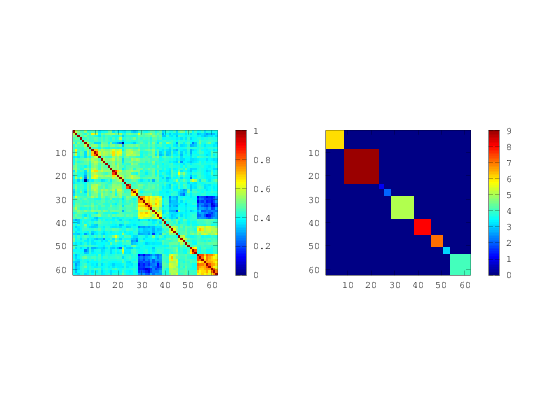

In [41]:
order = niak_hier2order(hier); % order the regions based on the hierarchy
subplot(1,2,1)
% Re-order the correlation matrix
title('re-ordered correlation matrix')
imagesc(R(order,order)), axis square, colorbar
subplot(1,2,2)
% Show the re-ordered partition
title('re-ordered partition')
niak_visu_part(part(order)), axis square

In [42]:
LABELS_Y(order)

ans = 
{
  [1,1] = Age_in_Yrs
  [2,1] = SSAGA_Income
  [3,1] = Zygosity
  [4,1] = GaitSpeed_Comp
  [5,1] = Odor_Unadj
  [6,1] = Gender
  [7,1] = Dexterity_Unadj
  [8,1] = Handedness
  [9,1] = SSAGA_Educ
  [10,1] = ReadEng_Unadj
  [11,1] = PicVocab_Unadj
  [12,1] = NEOFAC_O
  [13,1] = PicSeq_Unadj
  [14,1] = IWRD_TOT
  [15,1] = ER40_CR
  [16,1] = SCPT_SEN
  [17,1] = SCPT_SPEC
  [18,1] = PMAT24_A_CR
  [19,1] = PMAT24_A_RTCR
  [20,1] = VSPLOT_TC
  [21,1] = Endurance_Unadj
  [22,1] = Strength_Unadj
  [23,1] = Mars_Final
  [24,1] = DDisc_AUC_200
  [25,1] = DDisc_AUC_40K
  [26,1] = CardSort_Unadj
  [27,1] = Flanker_Unadj
  [28,1] = ProcSpeed_Unadj
  [29,1] = LifeSatisf_Unadj
  [30,1] = MeanPurp_Unadj
  [31,1] = PosAffect_Unadj
  [32,1] = Friendship_Unadj
  [33,1] = EmotSupp_Unadj
  [34,1] = InstruSupp_Unadj
  [35,1] = NEOFAC_A
  [36,1] = NEOFAC_E
  [37,1] = SelfEff_Unadj
  [38,1] = NEOFAC_C
  [39,1] = Race
  [40,1] = Ethnicity
  [41,1] = Taste_Unadj
  [42,1] = PSQI_Score
  [43,1] = FearSomat

with that ordering, by construction the solution of the hierarchical clustering are squares on the diagonal. If you are lucky, the similarity matrix will also look like it has squares on the diagonal.  

Now it is time to implement a boostrap analysis of stable clusters. The steps of the algorithm are as follows: 
 * Let's start by resample the data many times
 * re-run the clustering on each replication
 * represent each cluster solution as an adjacency matrix
 * compute the average of the adjacency matrix. This matrix, called stability or co-occurence, tells you the frequency at which a pair of regions fall into the same cluster. 

In [43]:
nb_samp = 1000;
opt_b.block_length = 1; % That's a parameter for the bootstrap. We treat the subjects as independent observations. 
for ss = 1:nb_samp
    niak_progress(ss,nb_samp)
    y_s = niak_bootstrap_tseries(y,opt_b); % Bootstrap the subjects
    R_s = corr(y_s); % compute the correlation matrix for the bootstrap sample
    hier = niak_hierarchical_clustering(R_s,struct('flag_verbose',false)); % replication the hierarchical clustering
    part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); % Cut the hierarchy to get clusters
    mat = niak_part2mat(part,true); % convert the partition into an adjacency matrix
    if ss == 1; stab = mat; else stab = stab+mat; end; % Add all adjacency matrices
end
stab = stab / nb_samp; % Divide by the number of replications to get the stability matrix

    Percentage done: 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100


Let's have a look at the stability matrix:

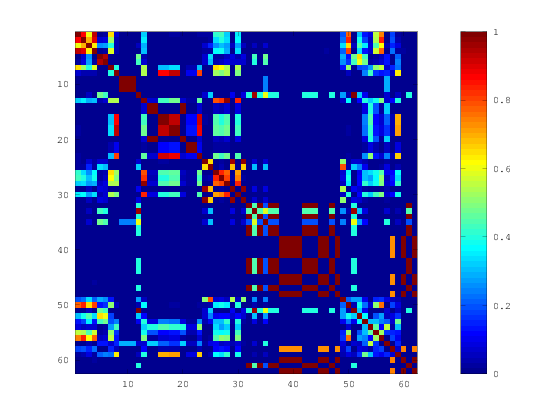

In [44]:
imagesc(stab), axis square, colormap(jet), colorbar

Looks like the clusters are pretty stable. Also note that the stability matrix ressembles a lot the original similarity matrix, except that the cluster structure is much cleaner. So let's use this stability matrix as the input of a new clustering! We are now looking for clusters of regions which have a high probability of falling into the same clusters. This step is called consensus clustering. 

     Percentage done : 0 7 11 16 21 26 31 36 41 46 51 56 61 66 70 75 80 85 90 95 100 Done ! 


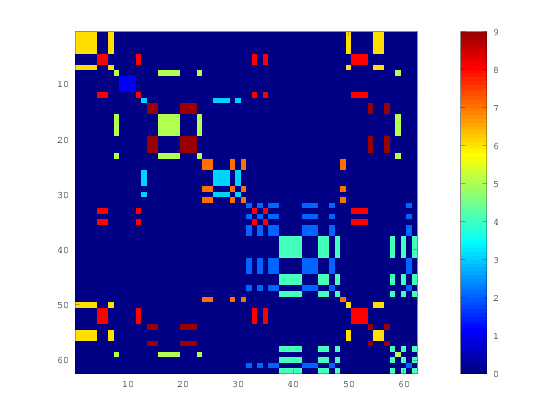

In [45]:
hier_consensus = niak_hierarchical_clustering(stab); % run a hierarchical clustering on the stability matrix
part_consensus = niak_threshold_hierarchy(hier_consensus,struct('thresh',nb_cluster)); % cut the consensus hierarchy
niak_visu_part(part_consensus), axis square, colormap(jet) % visualize the consensus partition

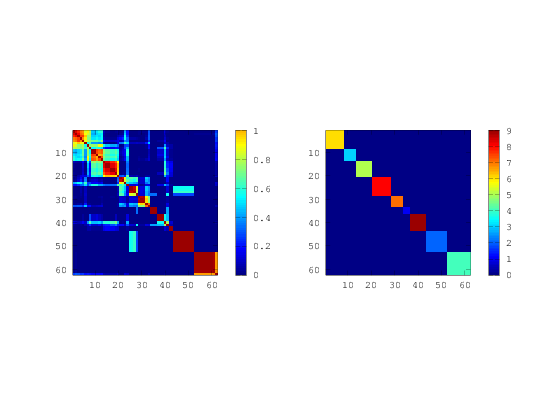

In [46]:
order_consensus = niak_hier2order(hier_consensus); % order the regions based on the hierarchy
subplot(1,2,1)
% Re-order the correlation matrix
title('re-ordered consensus matrix')
imagesc(stab(order_consensus,order_consensus)), axis square, colorbar
subplot(1,2,2)
% Show the re-ordered partition
title('re-ordered partition')
niak_visu_part(part_consensus(order_consensus)), axis square

Still not perfect but a bit better... In general the consensus cluster has better performance than the individual cluster solution. This is a general machine learning approach called bagging (for bootstrap aggregation).

In [70]:
for ii = 1:nb_cluster
    fprintf('Cluster %i: \n',ii)
    mask = zeros(size(order_consensus));
    mask = part_consensus(order_consensus) == ii;
    labels_pheno = LABELS_Y(order_consensus)(mask);
    for ss = 1:size(labels_pheno)(1)
        fprintf('     %s \n',labels_pheno{ss})
    end
end
    
    

Cluster 1: 
     BMI 
     BPSystolic 
     BPDiastolic 
Cluster 2: 
     Sadness_Unadj 
     AngHostil_Unadj 
     FearAffect_Unadj 
     PercReject_Unadj 
     Loneliness_Unadj 
     PercHostil_Unadj 
     AngAffect_Unadj 
     NEOFAC_N 
     PercStress_Unadj 
Cluster 3: 
     PicSeq_Unadj 
     IWRD_TOT 
     ER40_CR 
     SCPT_SEN 
     SCPT_SPEC 
Cluster 4: 
     LifeSatisf_Unadj 
     SelfEff_Unadj 
     MeanPurp_Unadj 
     PosAffect_Unadj 
     EmotSupp_Unadj 
     Friendship_Unadj 
     NEOFAC_E 
     InstruSupp_Unadj 
     NEOFAC_C 
     NEOFAC_A 
Cluster 5: 
     SSAGA_Educ 
     ReadEng_Unadj 
     PicVocab_Unadj 
     PMAT24_A_CR 
     PMAT24_A_RTCR 
     VSPLOT_TC 
     NEOFAC_O 
Cluster 6: 
     Age_in_Yrs 
     Zygosity 
     Gender 
     Odor_Unadj 
     Dexterity_Unadj 
     Handedness 
     SSAGA_Income 
     GaitSpeed_Comp 
Cluster 7: 
     VSPLOT_CRTE 
     IWRD_RTC 
     ER40_CRT 
     SCPT_TPRT 
     Noise_Comp 
Cluster 8: 
     Race 
     Ethnicity 
     Taste_U

One last question. Which region in the consensus cluster #1 (for example) are actually stable? We can combine the sability matrix and the consensus clusters to answer this question. 

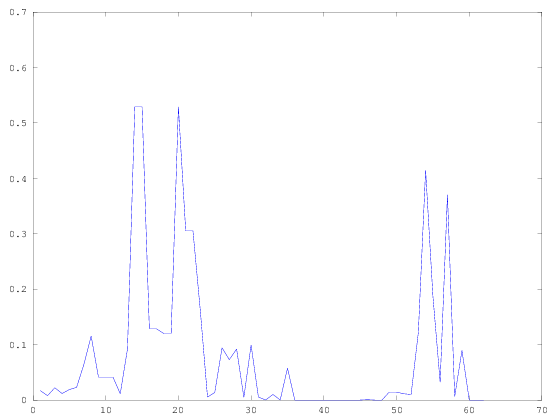

In [71]:
map = mean(stab(:,part_consensus==9),2); % Stability "map" of the first consensus cluster
plot(map)

For each region, we have the average stability between this region and all regions in consensus cluster #1 (which happen to be very close to our simulated cluster #1, but it could be any other cluster). For regions in the true cluster, the stability is about 0.6, while in other regions, it is about 0.25. Not bad. An ideal situation would be 1 within cluster, and 0 between cluster. We can also see each region happen to be less stable in that cluster. If each region corresponded to a parcel in the brain, we could represent this vector as a brain map. 